In [1]:
# Choose a random number of 6 digits. Make sure that you keep a copy of this number and avoid trivial numbers, such as 000000 or 123456 -- thank you!
# bleh

# Assignment 1 - Visualisation and Performance Evaluation

First assessed coursework for the course: Técnicas e Algoritmos em Ciência de Dados 

## General guidelines:

* This work must be entirely original. You are allowed to research documentation for specific libraries, but copying solutions from the internet or your classmates is strictly prohibited. Any such actions will result in a deduction of points for the coursework.
* Please enter your code in the designated areas of the notebook. You can create additional code cells to experiment with, but __make sure to place your final solutions where they are requested in the notebook.__
* The notebook already imports all the necessary libraries for this assignment at the beginning. Although you are allowed to import other libraries, it is not necessary.
* Before submitting your work, make sure to rename the file to your random number that you created above (for example, 289479.ipynb).

## Notebook Overview:

1. [Data Loading and Visualisation](#Data-Loading-and-Visualisation) (20%)
2. [Binary Classification Building a ROC curve](#Binary-Classification-Building-a-ROC-curve) (50%)
3. [Regression RMSE](#Regression-RMSE) (30%)

In [3]:
%matplotlib inline
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score 
from math import sqrt

## Data Loading and Visualisation

* Load the Iris dataset that you downloaded from the following link: https://www.kaggle.com/datasets/uciml/iris/download?datasetVersionNumber=2
* __Important:__ to ensure proper execution of your code, you need to either place the downloaded .csv file in the same working directory as the program or specify the correct path to the file.
* Load the data into a pandas `DataFrame`
* For each feature in the dataset, create a figure with two subplots one on top of the other.
    * In the first subplot, plot a histogram of the values of the feature for all classes combined. 
    * In the second subplot, plot a histogram of the values of the feature for each class separately. Use the column “Species” as the class identifier, and a different color for each class. 
    

* __Note:__ the data contains a column "Id" that you can ignore. 

In [4]:
# Load the data
# your code goes here

iris = pd.read_csv("Iris.csv")

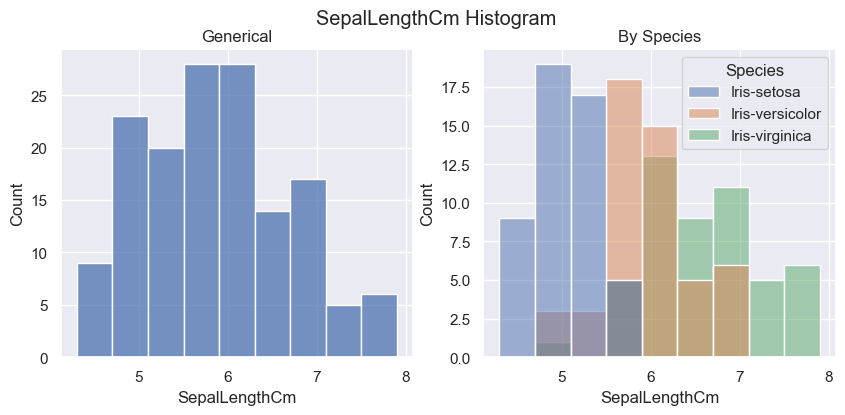

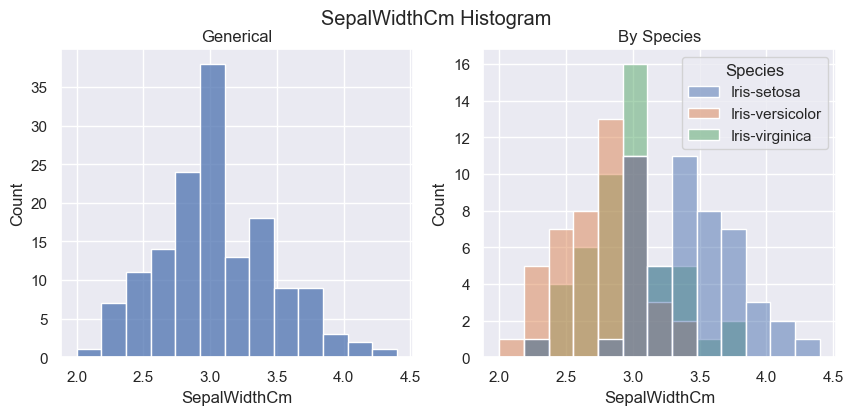

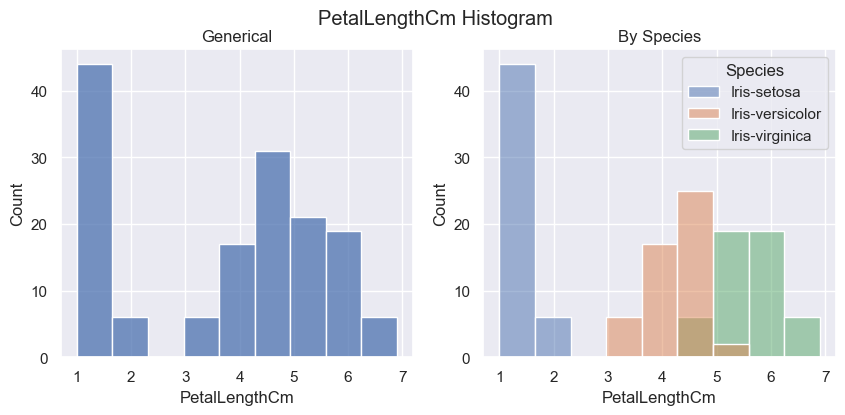

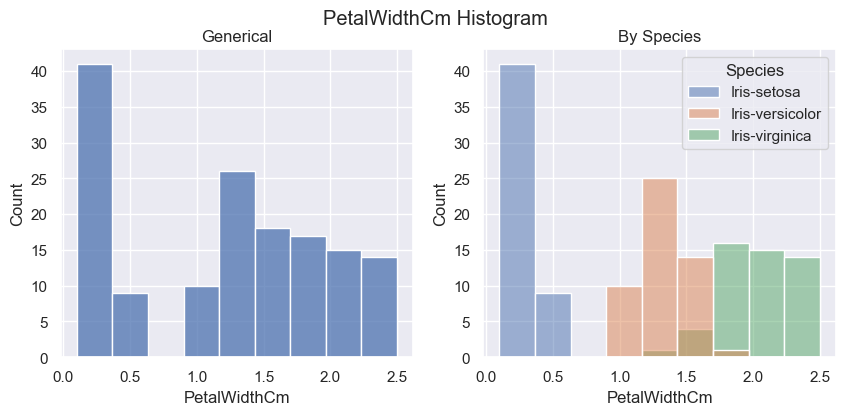

In [5]:
# The code for your plots go here

sns.set()

for column in range(1,5):
    feature = iris.iloc[:, column].name

    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    fig.suptitle(f"{feature} Histogram")
    
    sns.histplot(ax=axes[0], data = iris, x = feature)
    axes[0].set_title("Generical")
    sns.histplot(ax=axes[1], data = iris, x = feature, hue="Species")      
    axes[1].set_title("By Species")       

## Binary Classification Building a ROC curve

The goal of this exercise is to evaluate the performance of various pre-trained classification models in predicting whether a mushroom is edible or poisonous. To achieve this, we will generate ROC curves for each algorithm and determine the area under the curve. Using these metrics, we will decide which classifier is best suited for the task.

Follow the instructions in the cells below to complete this task.

In [6]:
# Loading the pre-trained classifiers and testing data
classifiers = pkl.load(open('classifiers_dict.p','rb'))
mushroom_test_data = pkl.load(open('mushroom_test_data.p','rb'))

The loaded variables are dictionaries. One contains the pre-trained classifiers and the other one the testing data. 

Let's inspect the contents of the classifiers_dict

In [7]:
classifiers

{'Categorical NB': CategoricalNB(),
 'Logistic Regression': LogisticRegression(max_iter=600),
 'SVM': SVC(probability=True),
 'Gradient Boosting': GradientBoostingClassifier()}

* We can see that the key is the name of the classifier and the value contains the pre-trained instance of each classifier. 
* In the next code cell there's code to extract the classifiers into separate variables.

In [8]:
cnb_clf = classifiers['Categorical NB']
lr_clf = classifiers['Logistic Regression']
svm_clf = classifiers['SVM']
gb_clf = classifiers['Gradient Boosting']

Next we'll extract the testing data from the mushroom_test_data dictionary we just loaded.

First, let's inspect the keys of the dictionary (we don't look at the values because the data is rather large and we don't want it to take up the whole screen).

In [9]:
mushroom_test_data.keys()

dict_keys(['X_test', 'y_test'])

* X_test contains the data points with their features that will serve as the input to our trained models.
* y_test contains the true labels for the testing set, which we'll use to evaluate our predictions.

In [10]:
X_test = mushroom_test_data['X_test']
y_test = mushroom_test_data['y_test']

As we can see below, X_test contains the 21 features that were used to train the different classifiers. 
* __Note__ that the index is shuffled because this is a random subset of the original data that we are using as our testing set.

In [11]:
X_test.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
700,5,2,4,1,6,1,0,1,10,0,...,2,2,7,7,2,1,4,2,3,1
6743,2,2,2,0,8,1,0,1,0,1,...,1,2,6,6,2,1,0,7,4,0
1571,5,0,8,0,5,1,1,0,4,1,...,2,0,7,7,2,1,0,2,0,1
5949,5,3,4,0,5,1,1,1,10,0,...,0,2,7,4,2,1,0,7,4,2
3307,2,3,4,1,5,1,0,0,5,1,...,2,2,7,6,2,1,4,3,5,0


During class we looked at the case where the output of the classifier is a number between 0 and 1. This is the case for the classifiers we will use here. For these classifiers this output can be interpreted as the probabilities.

We are now going to obtain the predicted probabilities from our different classifiers
* To do this we are using the method `predict_proba()`
* This is a method specific to each classifier and it requires as input argument the datapoints of our testing set with their features (`X_test`).

In [12]:
y_proba_cnb = cnb_clf.predict_proba(X_test)
y_proba_svm = svm_clf.predict_proba(X_test)
y_proba_lr = lr_clf.predict_proba(X_test)
y_proba_gb = gb_clf.predict_proba(X_test)

Let's inspect one of the variables we just created. 

We notice that it contains two values per row that sum up to 1. The first value is the probability of class 0 and the second value is the probability of class 1.

__For this exercise, you will use only the second column (probability of class 1) as was explained in class.__

In [13]:
y_proba_lr[:,1]

array([0.51438462, 0.49739115, 0.44828758, ..., 0.49417989, 0.46530429,
       0.45038901])

## Calculating the false positive and true positive rates
Now that we have our predicted values and the true labels, we are ready to calculate the ROC curve

Feel free to define the function(s) in a way that you find most comfortable. The goal of these functions is to generate the False Positive Rates (FPRs) and True Positive Rates (TPRs) at different thresholds for all classifiers.

The cell below contains a suggestion on how you can structure the function -- you can also do it differently if you prefer.

In [14]:
# # The following is just example code, it is not meant to be executed.
# def get_fpr_tpr(predicted_values, true_labels, threshold):
#     # body of the function
#     return fpr, tpr
# # this function would calculate the confusion matrix and then the fpr and tpr and return it as two separate values. 

# # to then use the output values of this function you would do something like:
# fpr, tpr = get_fpr_tpr(y_proba_lr, y_test, threshold)
y_test

700     1
6743    1
1571    0
5949    0
3307    0
       ..
7154    1
5293    1
2030    0
1578    0
3094    0
Name: class, Length: 1625, dtype: int64

In [15]:
# Your code goes here!!
def get_fpr_tpr(predicted_values, true_labels, threshold):
    prediction_vector = np.zeros(true_labels.size)
    tp, fp, tn, fn = 0, 0, 0, 0  
    
    for i in range(0, true_labels.size):
        if predicted_values[i, 1] > threshold:
            prediction_vector[i] = 1

        if prediction_vector[i] > true_labels.iloc[i]: fp += 1
        elif prediction_vector[i] < true_labels.iloc[i]: fn += 1
        elif prediction_vector[i] == 1: tp += 1
        else: tn += 1

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn) 
    return fpr, tpr 

threshold = 0.5
fpr, tpr = get_fpr_tpr(y_proba_lr, y_test, threshold)


## Plotting the ROC curve
Now let's use the calculated FPRs and TPRs to plot the ROC curves for the different classifiers.

The template below provides the typical structure of a superimposed plot, but you're welcome to modify it to fit your needs.

In [16]:
# # Here you must complete the calls to plt.plot() with the right input arguments
# # Following that you will need to generate the correct plot properties below
# fig = plt.figure(figsize=(8,6))
# # ROC Curve for the Categorical Naive Bayes
# plt.plot()
# # ROC Curve for Logistic Regression
# plt.plot()
# # ROC Curve for SVM
# plt.plot()
# # ROC Curve for Gradient Boosting
# plt.plot()

# # Plot properties
# # Title

# # X-Ticks and X-label 

# # Y-Ticks and Y-label

# # Legend

# plt.show()

## BONUS (10% extra marks)
You get bouns points if you make the plot using a single call to a plotting function.
* _Tip: use pandas and seaborn for this_

In [17]:
# I'll define a function to join all the fpr and tpr rates of one classifier in a single dataframe,
# with the classifier name in an adjaccent collumn
def fpr_tpr_dataframe(predicted_values, true_labels, classifier):
    dataframe = pd.DataFrame(columns=["FPR", "TPR", "Classifier"])
    
    for datapoint in predicted_values[:,1]:
        fpr, tpr = get_fpr_tpr(predicted_values, true_labels, datapoint)
        line = pd.DataFrame({"FPR": [fpr], "TPR": [tpr], "Classifier": [classifier]})
        dataframe = pd.concat([dataframe, line], ignore_index = True)

    return dataframe
    

<Axes: xlabel='FPR', ylabel='TPR'>

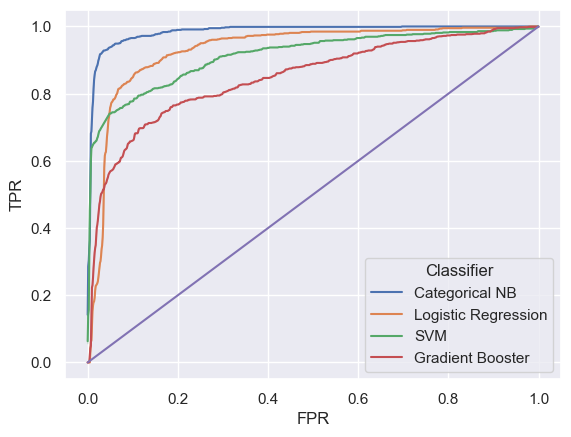

In [18]:
# Your code goes here

cnb_dataframe = fpr_tpr_dataframe(y_proba_cnb, y_test, "Categorical NB")
lr_dataframe = fpr_tpr_dataframe(y_proba_lr, y_test, "Logistic Regression")
svm_dataframe = fpr_tpr_dataframe(y_proba_svm, y_test, "SVM")
gb_dataframe = fpr_tpr_dataframe(y_proba_gb, y_test, "Gradient Booster")
dummy_dataframe = pd.DataFrame({"FPR": [0,1], "TPR": [0,1], "Classifier": ["_Comparison", "_Comparison"]})

roc_dataframe = pd.concat([cnb_dataframe, lr_dataframe, svm_dataframe, gb_dataframe, dummy_dataframe], ignore_index=True)
# print(roc_dataframe)

sns.lineplot(data=roc_dataframe, x="FPR", y="TPR", hue="Classifier") # I want my bonus :D
# This cell takes a lot of time to run, but it will work!!!



## Area under the curve
You are not expected to code a function to calculate the area under the ROC curve. Instead you have to use the provided function: `roc_auc_score()` to obtain this value. 

_Make sure to check the relevant documentation for this sklearn function._
* __Important: remember that we only care about the second column of our predicted probabilities!__

In [20]:
roc_dataframe[fpr]

,FPR,TPR,Classifier
0,0.163895,0.980843,Categorical NB
1,0.005938,0.637292,Categorical NB
2,0.938242,1.000000,Categorical NB
3,0.017815,0.871009,Categorical NB
4,0.602138,0.998723,Categorical NB
...,...,...,...
1620,0.005938,0.633461,Categorical NB
1621,0.000000,0.194125,Categorical NB
1622,0.239905,0.991060,Categorical NB
1623,0.804038,1.000000,Categorical NB


In [19]:
# Fill in your code where necessary
cnb_auroc = roc_auc_score( y_test, y_proba_cnb[:,1])
print("The AUROC for the Categorical Naive Bayes classifier is: {}".format(cnb_auroc))
svm_auroc = roc_auc_score(y_test, y_proba_svm[:,1])
print("The AUROC for the SVM classifier is: {}".format(svm_auroc))
lr_auroc = roc_auc_score(y_test, y_proba_lr[:,1])
print("The AUROC for the Logistic Regression classifier is: {}".format(lr_auroc))
gb_auroc = roc_auc_score(y_test, y_proba_gb[:,1])
print("The AUROC for the Gradient Boosting classifier is: {}".format(gb_auroc))

The AUROC for the Categorical Naive Bayes classifier is: 0.9848335927048353
The AUROC for the SVM classifier is: 0.9138818358041882
The AUROC for the Logistic Regression classifier is: 0.9315289570838755
The AUROC for the Gradient Boosting classifier is: 0.8482282347873306


After analyzing the ROC curves and calculating the area under the curves, it should be apparent that the Categorical Naive Bayes classifier outperforms the other classifiers and is the most suitable option for this particular problem.

## Regression RMSE

The final exercise of this coursework requires you to calculate the Root Mean Squared Error (RMSE) of a linear regression model that predicts house prices.

In [20]:
# Load the data and the pre-trained model
boston_testing_data = pkl.load(open('boston_testing_data.p','rb'))
linear_regression_model = pkl.load(open('linear_regression_model.p','rb'))

Again, we extract the testing features and the true values in separate variables. 
* __Important:__ I use different variable names because X_test and y_test are being used for exercise 2. There's no need for this, but just to avoid confusion and to not step on pre-existing variables

In [21]:
X_test_boston = boston_testing_data['X_test']
y_test_boston = boston_testing_data['y_test']
y_test_boston

477    2.564949
451    2.785011
29     3.091042
0      3.218876
312    3.015535
         ...   
376    2.701361
90     3.161247
78     3.100092
44     3.100092
350    3.173878
Name: MEDV, Length: 102, dtype: float64

Let's now obtain the predicted values

In [22]:
y_predict_lin_reg = linear_regression_model.predict(X_test_boston)
y_predict_lin_reg

array([2.52874038, 2.78182994, 3.05553426, 3.5195358 , 3.16364556,
       3.23025263, 3.14964632, 3.04034689, 2.95954982, 2.10626056,
       3.07322957, 2.9029627 , 3.58788491, 2.76785043, 2.79756944,
       2.80744397, 2.77228805, 2.82619075, 3.39671293, 2.98703859,
       3.56287069, 3.43173772, 3.21559375, 2.7894632 , 2.79523854,
       2.46043422, 3.49758847, 2.80669025, 2.64286995, 3.06888798,
       3.38659352, 2.28503429, 2.12157451, 3.15846407, 3.08009997,
       2.64024668, 2.81284333, 2.86981192, 3.63035309, 2.69832755,
       3.02988553, 3.1265449 , 3.79902884, 2.57159492, 2.8511767 ,
       3.65803297, 2.81608608, 2.2775767 , 3.21513946, 3.00140701,
       3.61910459, 2.47619814, 3.80754116, 2.85308226, 3.03598682,
       3.19039188, 3.03230638, 3.56971273, 3.64197822, 2.87762004,
       2.9489826 , 2.64907809, 3.1330453 , 3.00696002, 3.14307871,
       3.53208903, 3.30059112, 2.84852853, 2.8162628 , 2.83395641,
       3.14667461, 2.84711643, 2.93729089, 3.05561233, 3.31533

## Calculating RMSE
Now you have to write code to calculate the root mean squared error on the testing set for the linear regression model we just loaded.
At the end, just print the RMSE value for verification.

In [23]:
# Your code goes here
# I've done the bonus code directly


## BONUS (5% extra marks)
You get this bonus marks if you are able to calculate the RMSE by vectorising your code, that is, no loops whatsoever.

In [24]:
# Your code for the bonus marks goes here

def root_mean_square(predict, test):
    result_array = (predict - test)**2
    RMS_error = sqrt(np.sum(result_array)/predict.size)
    return RMS_error

RMS_error = root_mean_square(y_predict_lin_reg, y_test_boston)
RMS_error

0.19420633754814495